### Part. 2, Task A:

In [ ]:
%load_ext autoreload
%autoreload 2
import h5py
import pickle
import dynamiqs as dq
import matplotlib.pyplot as plt
import numpy as np
from scipy.ndimage import gaussian_filter
import jax.numpy as jnp
from tqdm.notebook import tqdm
from src.utilities import (
    wigner_affine_correction,
    rho_reconstruction
)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Denoise data

We know that the Wigner function vanishes at infinity. In our case, we suppose that the actual Wigner function of the system vanishes near the edges of the phase space that we know is a 6 by 6 space. We then implement a circle that will separate the space in two areas, the one in the center where the actual Wigner function is most kikely to be non-zero and the other one where the actual Wigner function vanished. In the region, the measured Wigner function is constant and equal to b + noise. Averaging over this surface will give us b as the noise averages to zero.

- step 1: average points on the edges to find the bias b
- step 2: integrate over the unbiased data, this gives the sacling factor a
- step 3: apply $W_{corrected} = \frac{W_{initial}-b}{a}$ 
- step 4: apply a 2D gaussian filter

  0%|          | 0/8 [00:00<?, ?it/s]

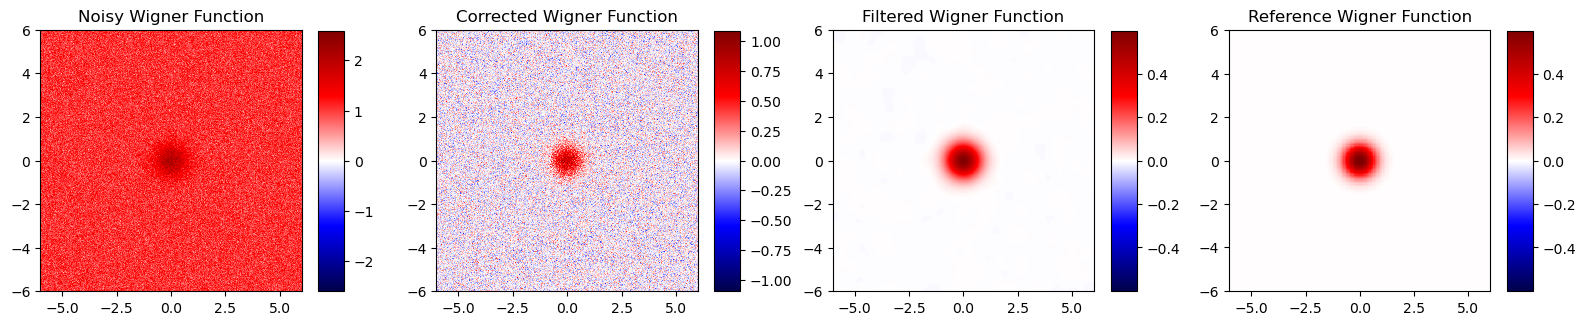

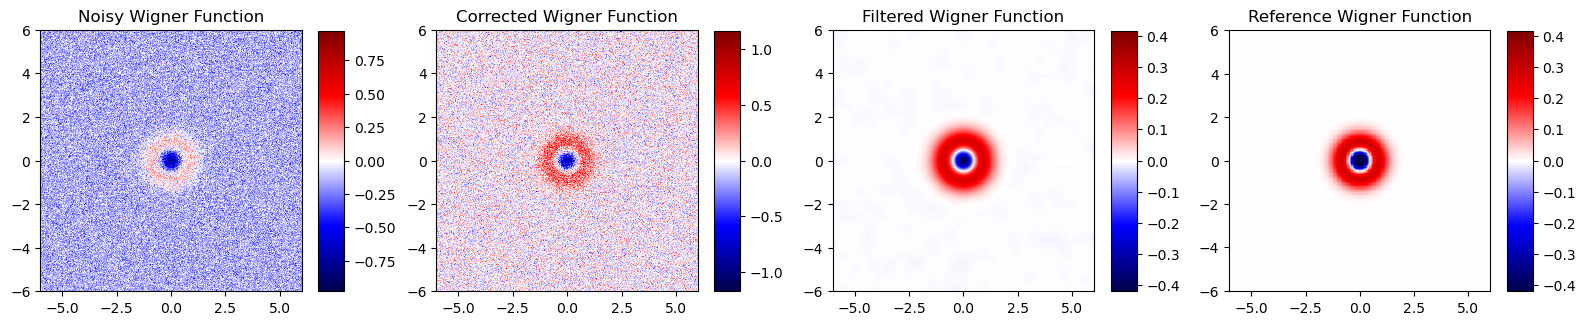

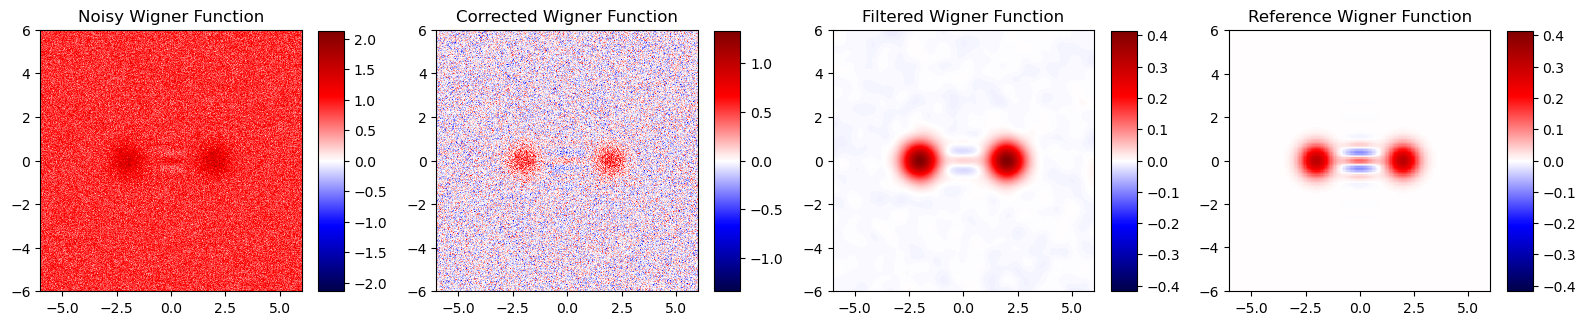

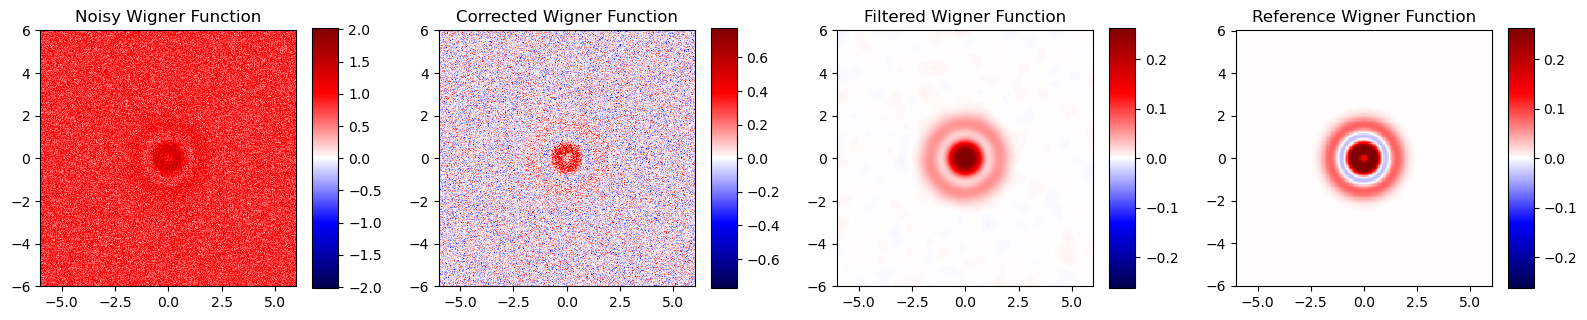

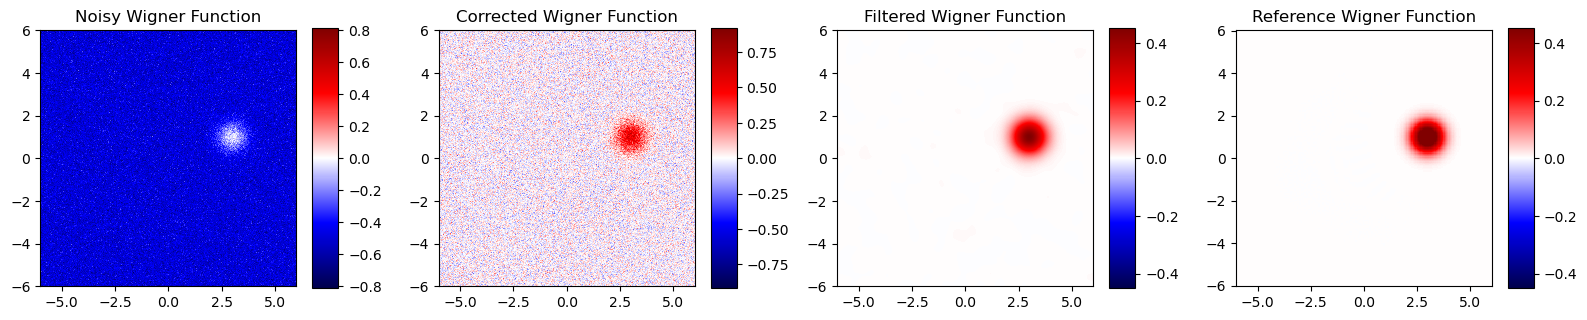

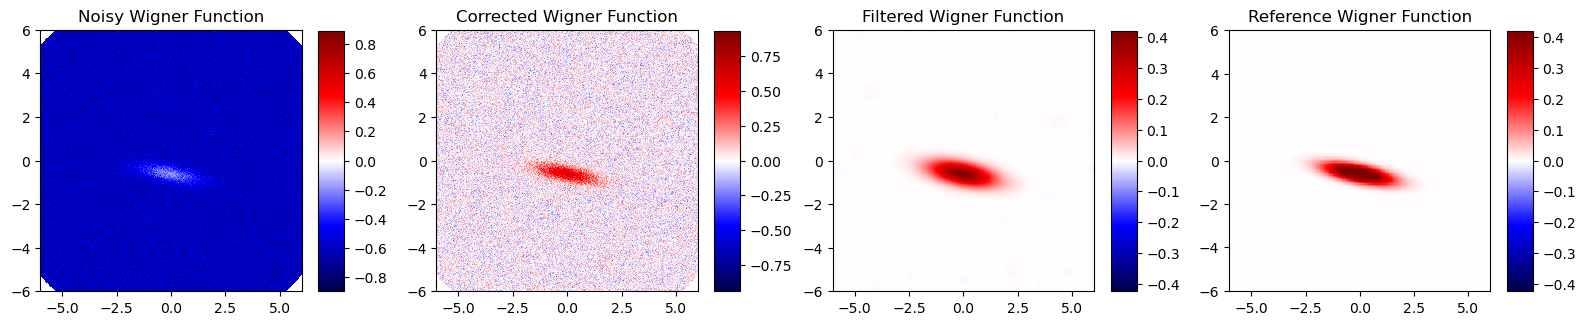

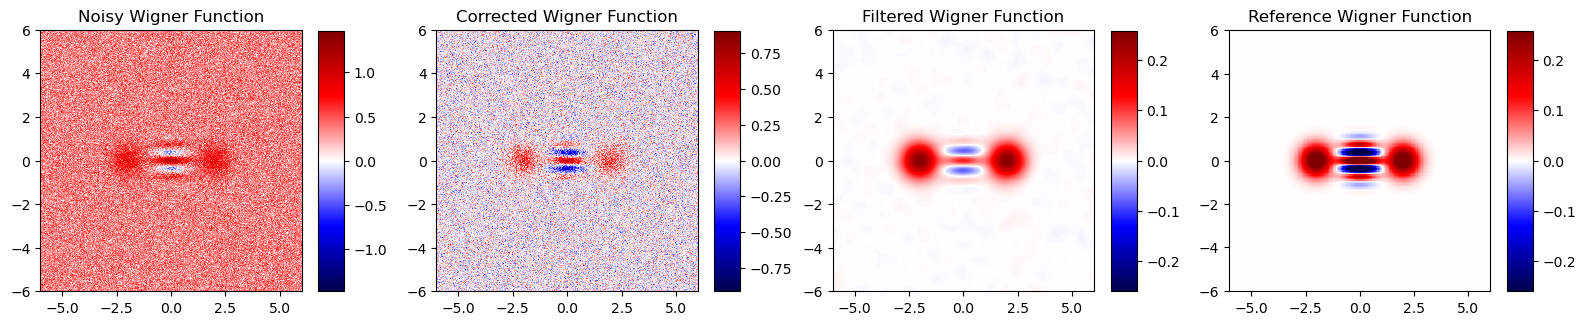

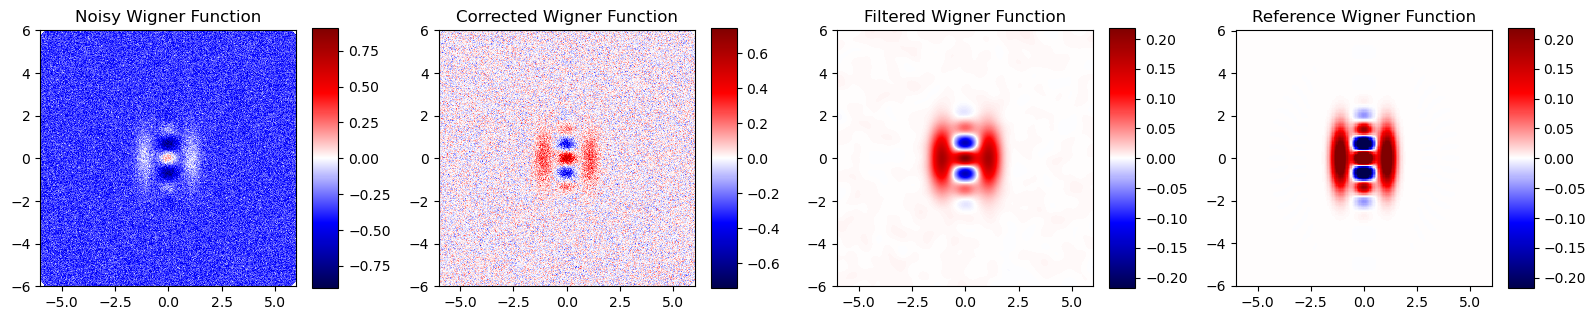

In [77]:
sigma = 20.0
results = {}
for i in tqdm(range(8)):
    wigner_function_filename = f'data/synthetic/noisy_wigner_{i}.pickle'
    with open(wigner_function_filename, 'rb') as f:
        x_values, y_values, wigner_values = pickle.load(f)

    # Load the “true” quantum state for plotting
    quantum_state_filename = f'data/synthetic/quantum_state_{i}.pickle'
    with open(quantum_state_filename, 'rb') as f:
        rho_reference = pickle.load(f)

    # Affine correction
    corrected_wigner, normalization, offset = wigner_affine_correction(x_values, y_values, wigner_values)
    filtered_wigner = gaussian_filter(corrected_wigner, sigma=sigma)

    # Store results in a dictionary
    results[i] = {
        "x_values": x_values,
        "y_values": y_values,
        "wigner_values": wigner_values,
        "rho_reference": rho_reference,
        "corrected_wigner": corrected_wigner,
        "filtered_wigner": filtered_wigner,
        "normalization": normalization,
        "offset": offset
    }

    # Plotting (optional)
    fig, ax = plt.subplots(1, 4, figsize=(16, 5.5))
    max_val = max(abs(np.nanmin(wigner_values)), abs(np.nanmax(wigner_values)))
    map0 = ax[0].pcolormesh(x_values, y_values, wigner_values.T, cmap='seismic', vmin=-max_val, vmax=max_val)
    ax[0].set_aspect('equal')
    ax[0].set_title('Noisy Wigner Function')
    max_val = max(abs(np.nanmin(corrected_wigner)), abs(np.nanmax(corrected_wigner)))
    map1 = ax[1].pcolormesh(x_values, y_values, corrected_wigner.T, cmap='seismic', vmin=-max_val, vmax=max_val)
    ax[1].set_aspect('equal')
    ax[1].set_title('Corrected Wigner Function')
    max_val = max(abs(np.nanmin(filtered_wigner)), abs(np.nanmax(filtered_wigner)))
    map2 = ax[2].pcolormesh(x_values, y_values, filtered_wigner.T, cmap='seismic', vmin=-max_val, vmax=max_val)
    ax[2].set_aspect('equal')
    ax[2].set_title('Filtered Wigner Function')
    
    x_values, y_values, rho_true = dq.wigner(rho_reference)
    map3 = ax[3].pcolormesh(x_values, y_values, rho_true.T, cmap='seismic', vmin=-max_val, vmax=max_val)
    ax[3].set_aspect('equal')
    ax[3].set_title('Reference Wigner Function')
    fig.colorbar(map0, ax=ax[0], shrink=0.5, aspect=10)
    fig.colorbar(map1, ax=ax[1], shrink=0.5, aspect=10)
    fig.colorbar(map2, ax=ax[2], shrink=0.5, aspect=10)
    fig.colorbar(map3, ax=ax[3], shrink=0.5, aspect=10)

    fig.tight_layout()
    plt.show()

# Save the results dictionary to a file (optional)
with open('results.pkl', 'wb') as f:
    pickle.dump(results, f)

In [49]:
idx = 1
sigma = 40.0
sigma_array = np.linspace(0.0, 100.0, 10)

for i in tqdm(range(8)):
    results[i] = {}
    for j, sigma in enumerate(sigma_array):
        wigner_function_filename = f'data/synthetic/noisy_wigner_{i}.pickle'
        with open(wigner_function_filename, 'rb') as f:
            xvec, pvec, wigner_values = pickle.load(f)

        # Load the “true” quantum state for plotting
        quantum_state_filename = f'data/synthetic/quantum_state_{i}.pickle'
        with open(quantum_state_filename, 'rb') as f:
            rho_reference = pickle.load(f)

        # Affine correction
        corrected_wigner, normalization, offset = wigner_affine_correction(xvec, pvec, wigner_values)
        filtered_wigner = gaussian_filter(corrected_wigner, sigma=sigma)

        results[i][j] = {
            "xvec": xvec,
            "pvec": pvec,
            "wigner_values": wigner_values,
            "rho_reference": rho_reference,
            "corrected_wigner": corrected_wigner,
            "filtered_wigner": filtered_wigner,
            "normalization": normalization,
            "offset": offset
        }

  0%|          | 0/8 [00:00<?, ?it/s]

In [ ]:
grid_number = 20
fidelity_filtered_array = np.zeros((8, len(sigma_array)))
fidelity_raw_array = np.zeros(8)

for i in tqdm(range(8)):
    
    xvec = results[i][0]["xvec"]
    pvec = results[i][0]["pvec"]
    rho_reference = results[i][0]["rho_reference"]
    xgrid = np.linspace(xvec.min(), xvec.max(), grid_number)
    pgrid = np.linspace(pvec.min(), pvec.max(), grid_number)
    alpha_list = [x + 1j*y for x in xgrid for y in pgrid]
    
    # Make nan to zero in results[i][0]["wigner_values"]
    results[i][0]["wigner_values"] = np.nan_to_num(results[i][0]["wigner_values"], nan=0.0)
    rho_rec, w_k, E_ops, metrics = rho_reconstruction(
            results[i][0]["wigner_values"],
            xvec=xvec,
            pvec=pvec,
            alpha_list= alpha_list,
            N_psi=rho_reference.shape[0],
            N_fit = 200,
            rho_reference=dq.asqarray(rho_reference),
        )
    
    fidelity_raw_array[i] = metrics.fidelity
    
    for j, sigma in enumerate(tqdm(sigma_array, leave=False)):
        
        rho_rec, w_k, E_ops, metrics = rho_reconstruction(
            results[i][j]["filtered_wigner"],
            xvec=xvec,
            pvec=pvec,
            alpha_list= alpha_list,
            N_psi=rho_reference.shape[0],
            N_fit = 200,
            rho_reference=dq.asqarray(rho_reference),
        )
        
        fidelity_filtered_array[i, j] = metrics.fidelity
        
with h5py.File('results2.hdf5', 'w') as f:
    f.create_dataset('fidelity_array', data=fidelity_filtered_array)
    f.create_dataset('fidelity_raw_array', data=fidelity_raw_array)
    f.create_dataset('sigma_array', data=sigma_array)
    f.create_dataset('indexes', data=np.arange(8))

  0%|          | 0/8 [00:00<?, ?it/s]

In [66]:
# Load the data from the hdf5 file
with h5py.File('results.hdf5', 'r') as f:
    fidelity_filtered_array = f['fidelity_array'][:]
    fidelity_raw_array = f['fidelity_raw_array'][:]
    sigma_array = f['sigma_array'][:]
    indexes = f['indexes'][:]

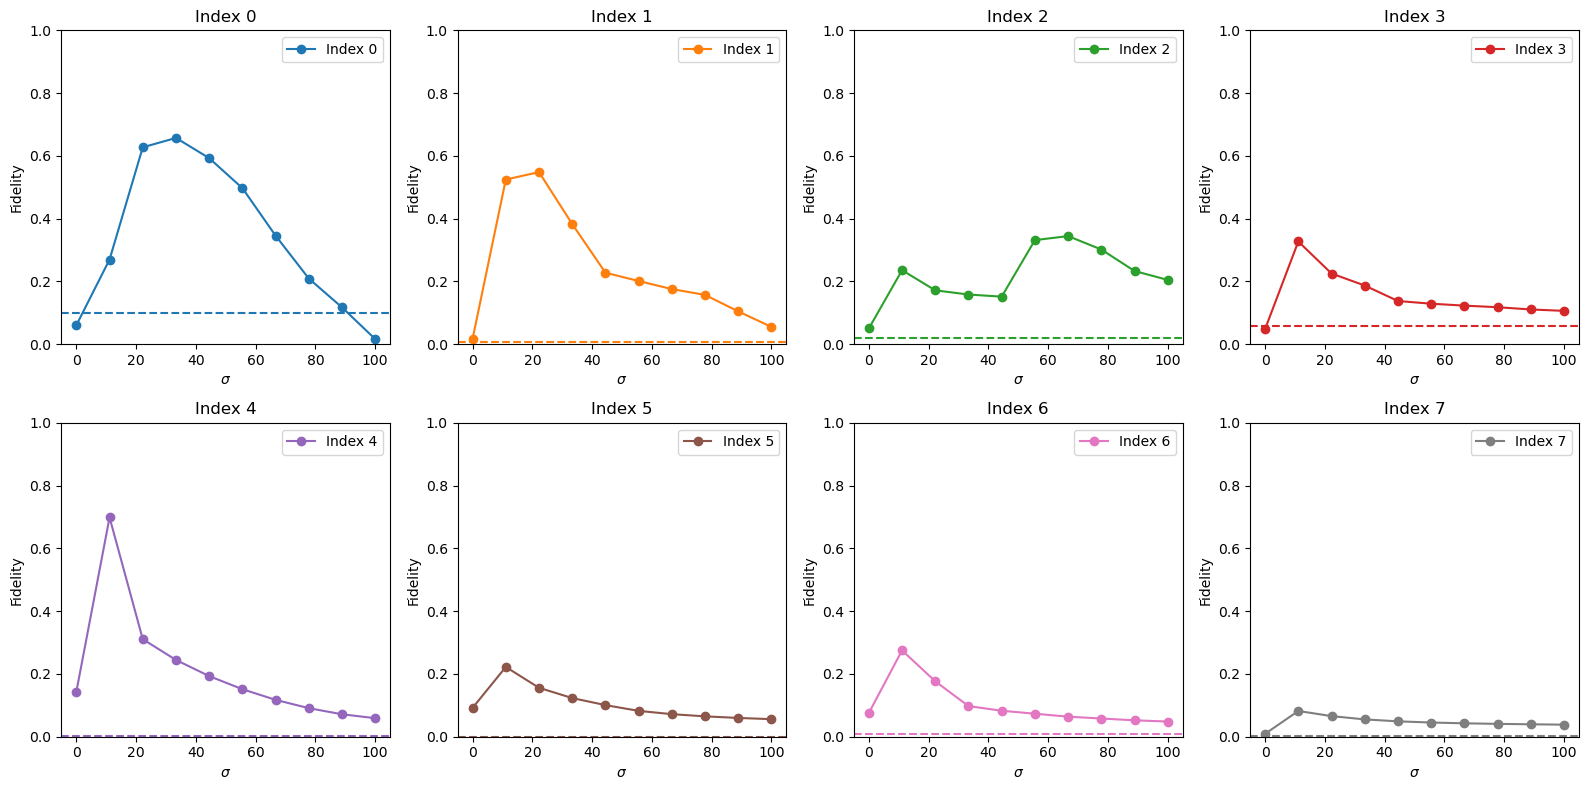

In [90]:
fig, axes = plt.subplots(2, 4, figsize=(16, 8))
axes = axes.flatten()

for i, ax in enumerate(axes):
    ax.plot(sigma_array, fidelity_filtered_array[i], 'o-', label=f'Index {i}', color=f'C{i}')
    ax.axhline(fidelity_raw_array[i], linestyle='--', color=f'C{i}')
    ax.set_xlabel(r'$\sigma$')
    ax.set_ylabel('Fidelity')
    ax.set_title(rf'Index {i}')
    ax.set_ylim(0, 1)
    ax.legend()

plt.tight_layout()
plt.show()